# Predicting future donation revenue for online events.

## Bootstrap estimation of confidence intervals

This notebook contains the code from the medium post:
https://medium.com/p/cca9dc855d1b/


In [1]:
# Import the packages needed

# number stuff
import pandas as pd
import numpy as np

# plotting stuff
import matplotlib.pyplot as plt
from matplotlib import ticker
%matplotlib inline
import seaborn as sns

# resampling
from sklearn.utils import resample

In [2]:
# Import the data into a Pandas Dataframe
# importing from the github repo so the notebook can be used in colab
url = 'https://github.com/benbogart/blog-2-bootstrap/blob/main/data/event_2_donations.csv?raw=true'
df = pd.read_csv(url, index_col=0)

## Get to know the data

In [3]:
# total amount donated
df.sum()

amount    2312.2
dtype: float64

In [4]:
# 5 point stats 
df.describe()

,amount
count,64.000000
mean,36.128125
std,46.502191
min,10.000000
25%,10.000000
50%,20.000000
75%,42.500000
max,303.000000


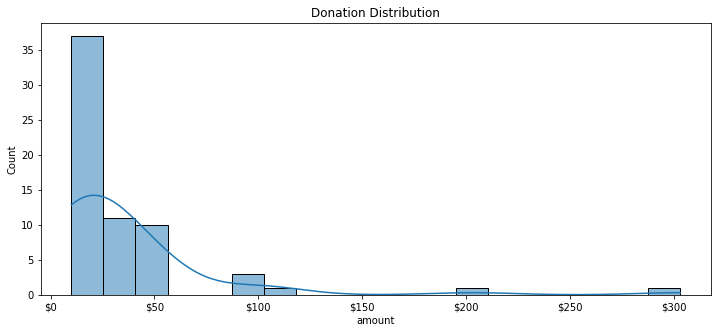

In [5]:
# plot the distribution of the donations

# set the size of the figure
plt.figure(figsize=(12,5))

# plot the histogram
ax = sns.histplot(df.amount, kde=True)

# set the title
plt.title('Donation Distribution')

# format the x axis as # amounts
formatter = ticker.FormatStrFormatter('$%1.0f')
ax.xaxis.set_major_formatter(formatter)

We can see from the 5 point stats that the minimum value for the Amount is 1. So the people who did not donate are not included.  We want to add them into this data as guests who donated zero.

This event had 126 people register.

To add those in we want to see the difference between the number of people who registered and the number of donations for that event, then pad the data with zeros for the people who didn't donate.

In [6]:
# count the number of people who did not donate by subtracting the total number
# of donations from the total number of registered attendees 
number_of_cheapskates = 126 - len(df)

# create a dataframe of 0's with length of equal to number_of_cheapskates
cheapskates = pd.DataFrame(np.zeros(number_of_cheapskates), 
                           columns = ['amount'])
cheapskates.head()

,amount
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


In [7]:
# check that we have the right number of cheapskates
len(cheapskates)

62

In [8]:
# create a new dataframe with all registered attendees and the amount 
# they donated.
df_combined = pd.concat([df, cheapskates])

# get the new mean
sample_mean = df_combined['amount'].mean()
round(sample_mean, 2)

18.35

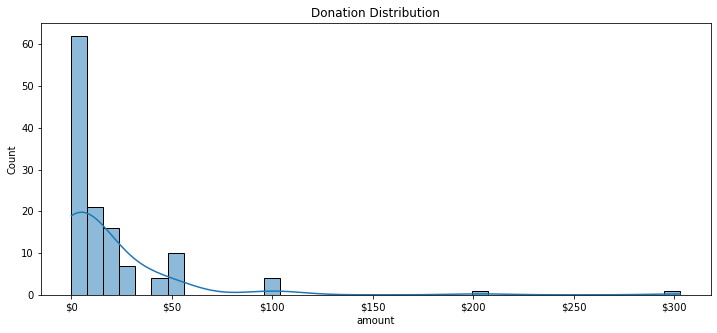

In [9]:
# plot the new distribution of the donations

# set the size of the figure
plt.figure(figsize=(12,5))

# plot the histogram
ax = sns.histplot(df_combined.amount, kde=True)

# set the title
plt.title('Donation Distribution')

# format the x axis as # amounts
formatter = ticker.FormatStrFormatter('$%1.0f')
ax.xaxis.set_major_formatter(formatter)

## Resample to find the population distributioin.

In [10]:
# set a random seed so if you rerun this notebook your results will exactly 
# match mine.
np.random.seed((3945))

# create an empy list to hold the resampled_means 
resample_means = []

# resample from our event data 10000 times and store the results in
# resample_means
for i in range(10000):
    resample_means.append(resample(df_combined.amount).mean())

In [11]:
# look at the first 5 resampled menas
resample_means[:5]

[19.173015873015874,
 17.05873015873016,
 13.087301587301587,
 19.142857142857142,
 16.847619047619048]

The mean of the resample_means will be about the same as the mean of our original sample.

In [12]:
print(f'Original Sample Mean: {round(sample_mean, 2)}')
print('Mean of resampled means:', round(np.mean(resample_means), 2))

Original Sample Mean: 18.35
Mean of resampled means: 18.38


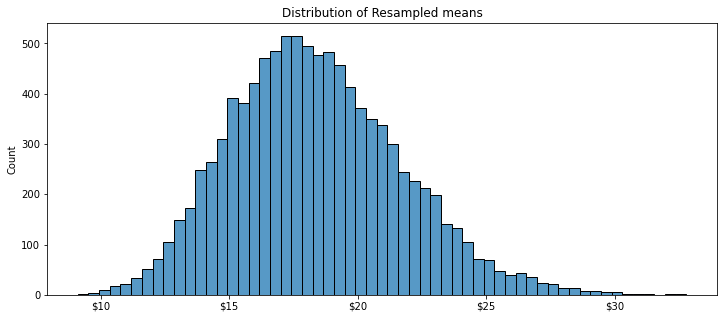

In [13]:
# Plot the distribution of the resampled means.

# set the size of the figure
plt.figure(figsize=(12,5))

# create the histogram
ax = sns.histplot(resample_means)

# set the title
plt.title('Distribution of Resampled means')

# format the x axis as $
formatter = ticker.FormatStrFormatter('$%1.0f')
ax.xaxis.set_major_formatter(formatter)


Calculate the 95% confidence interval by sorting `resample_mans` and taking the 250th and 9750th elements which correspond to the .025 quantile and the .975 quantile.

In [14]:
# sort resample_means
resample_means.sort()

# extract the confidence interval
np.round((resample_means[249], resample_means[9749]),2)

array([12.59, 25.46])

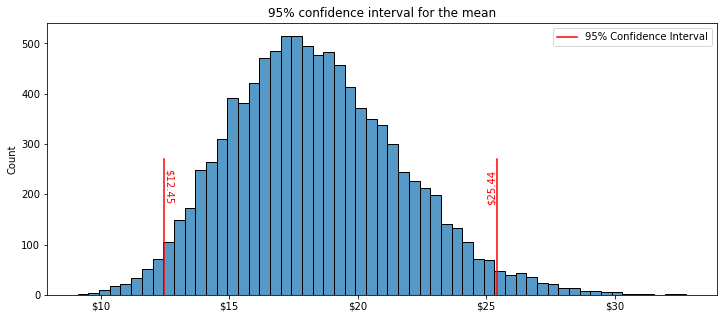

In [15]:
# visualize the confidence interval

# set the figure size
plt.figure(figsize=(12,5))

# plot histogram
ax = sns.histplot(resample_means)

# format the x axis as $
formatter = ticker.FormatStrFormatter('$%1.0f')
ax.xaxis.set_major_formatter(formatter)

# draw the vertical lines
ax.axvline(12.45, 0, .5, color='r', label='95% Confidence Interval')
ax.axvline(25.44, 0, .5, color='r')

# add text to the vertical lines
ax.text(12.45, 180, '$12.45', rotation=270, va='bottom', ha='left', color='r')
ax.text(25.4, 180, '$25.44', rotation=90, va='bottom', ha='right', color='r')

#set the title
plt.title('95% confidence interval for the mean')

# add a legend
plt.legend()

Find the value that the mean will be above 99% of the time.

In [16]:
resample_means.sort()
np.round(resample_means[99], 2)

11.68

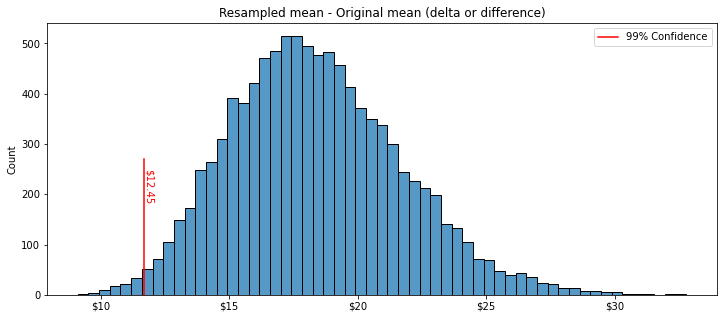

In [17]:
# visualize the low bound of the man 99% of trials.

# set figure size
plt.figure(figsize=(12,5))

# draw the plot
ax = sns.histplot(resample_means)

# format the x asix as $
formatter = ticker.FormatStrFormatter('$%1.0f')
ax.xaxis.set_major_formatter(formatter)

# draw a line to indicate the value
ax.axvline(11.68, 0, .5, color='r', label='99% Confidence')

# add text to the line
ax.text(11.68, 180, '$12.45', rotation=270, va='bottom', ha='left', color='r')

# set the titlle
plt.title('Resampled mean - Original mean (delta or difference)')

# add a legend
plt.legend()

# Plot convergance of confidence intervals

In [18]:
np.random.seed(8943)

# create an empy list to hold the resampled_means 
resample_deltas = []

# create x values from 10 to 40,000 by 10s
x = np.arange(4000)

# run the resample
for i in x:
    resample_deltas.append(resample(df_combined.amount).mean() - sample_mean)
    
resample_deltas[:5]

[8.92698412698413,
 -2.1349206349206327,
 5.168253968253971,
 1.7333333333333307,
 -1.349206349206348]

In [19]:
# initialize lists for y axis values
y1 = []
y2 = []

# get the quantiles each different numbers of samples
for i in x:
    y1.append(np.quantile(resample_deltas[:i+1],.025))
    y2.append(np.quantile(resample_deltas[:i+1],.975))
    
# show the first 5 rows
y1[:5]

[8.92698412698413,
 -1.8583730158730134,
 -1.7697619047619022,
 -1.8448015873015855,
 -2.0563492063492044]

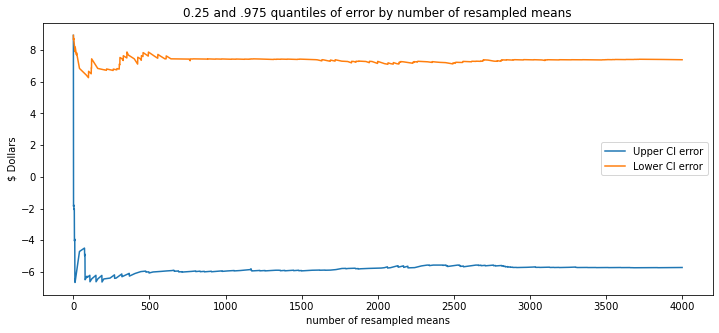

In [20]:
# visualise it


plt.figure(figsize=(12,5))
sns.lineplot(x=x, y=y1, label='Upper CI error')
sns.lineplot(x=x, y=y2, label='Lower CI error')

formatter = ticker.FormatStrFormatter('$%1.0f')
ax.yaxis.set_major_formatter(formatter)

plt.title('0.25 and .975 quantiles of error by number of resampled means')
plt.xlabel('number of resampled means')
plt.ylabel('$ Dollars')

plt.legend()